# Compare deepcoadds and Objects

 work with Weakly_2022_44
- use jupyter kernel LSST
- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab
- creation date : 2023/12/23
- update : 2023/12/29


In [1]:
! eups list -s | grep LOCAL

analysis_tools        LOCAL:/home/d/dagoret/repos/repos_w_2023_44/analysis_tools 	setup
atmospec              LOCAL:/home/d/dagoret/repos/repos_w_2023_44/atmospec 	setup
eups                  LOCAL:/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/eups 	setup
spectractor           LOCAL:/home/d/dagoret/repos/repos_w_2023_44/Spectractor 	setup


In [2]:
! eups list -s lsst_distrib

   g4213664e8e+d053631def 	current w_2023_44 setup


In [3]:
import lsst.daf.butler as dafButler
import lsst.daf.base as dafBase

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm 
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd
import pickle

plt.rcParams["figure.figsize"] = (4,3)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [5]:
import lsst.afw.image as afwImage
import lsst.afw.display as afwDisplay
import lsst.afw.table as afwTable
import lsst.geom as geom
import pprint

In [6]:
#Set the matplotlib plot color table.
plt.style.use('tableau-colorblind10')

In [7]:
# Let us also set `lsst.afw.display` to use the `matplotlib` backend:
afwDisplay.setDefaultBackend('matplotlib')
plt.rcParams['figure.figsize'] = (6.0, 6.0)

In [8]:
def convert_fluxtomag(x) :
    """
    The object and source catalogs store only fluxes. There are hundreds of flux-related columns, 
    and to store them also as magnitudes would be redundant, and a waste of space.
    All flux units are nanojanskys. The AB Magnitudes Wikipedia page provides a concise resource 
    for users unfamiliar with AB magnitudes and jansky fluxes. To convert to AB magnitudes use:
    As demonstrated in Section 2.3.2, to add columns of magnitudes after retrieving columns of flux, users can do this:
    results_table['r_calibMag'] = -2.50 * numpy.log10(results_table['r_calibFlux']) + 31.4
    results_table['r_cModelMag'] = -2.50 * numpy.log10(results_table['r_cModelFlux']) + 31.4
    (from DP0 tutorial)
    """
    return -2.50 * np.log10(x) + 31.4

## Config

### Butler repo and collection

In [9]:
#repo =  "/sdf/group/rubin/repo/main"
repo = "/sdf/group/rubin/repo/oga/"
butler = dafButler.Butler(repo)
registry = butler.registry

### Give the collection

In [10]:
my_collection = "LATISS/runs/AUXTEL_DRP_IMAGING_2023-11A-10A-09AB-08ABC-07AB-05AB/w_2023_46/PREOPS-4553"

### input files

- object file
- tract and patch

In [11]:
file_obs = "objectTable_202312.csv"
file_tractpatch = "Latiss_tractspatchs.pickle"

### DataId

- Tract 5615, patch 294 ou 313
- tract 5634, patch 72,73, 91, 92

In [12]:
tract = 5615
patch = 294
band = 'r'
skymap = 'latiss_v1'

In [13]:
the_dataId = {'skymap':skymap,'band': band, 'tract': tract, 'patch': patch}

In [14]:
the_title = f"Auxtel deepCoadd : band={band}, tract={tract}, patch={patch}" 

## Init

In [15]:
with open('Latiss_tractspatchs.pickle', 'rb') as handle:
    tracts_patchs_dict = pickle.load(handle)

In [16]:
tracts_patchs_dict

{5616: array([335, 355, 358, 336, 337, 338, 316, 357, 317, 356]),
 5634: array([ 91,  52,  93,  72,  92, 109, 110,  54,  71,  53,  55, 112, 111,
         74,  73,  90]),
 5615: array([332, 333, 312, 313, 295, 331, 276, 275, 294, 293, 314, 274]),
 10644: array([166, 184, 183, 201, 161, 180, 207, 188, 202, 182, 189, 208, 164,
        181, 185, 165, 203, 162]),
 383: array([359, 360]),
 8188: array([48, 65, 47, 28, 46, 66, 27]),
 3863: array([241, 243, 242, 260, 261, 222, 262, 224, 223]),
 455: array([52, 33, 51, 32, 14, 53, 34, 15, 13]),
 452: array([42, 44, 25, 24, 63, 23, 43, 62]),
 5839: array([9, 7, 8]),
 10643: array([171, 190]),
 382: array([343, 342])}

In [17]:
df = pd.read_csv(file_obs,index_col=0) 

In [18]:
selection1 =  (df["tract"] == tract) & (df["patch"] == patch)
selection2 = df["refExtendedness"] == False
selection3 = df["detect_isPrimary"] == True

In [19]:
df_sel = df[selection1 & selection2 & selection3]

In [20]:
df_sel["g_cModelMag"] = df_sel["g_cModelFlux"].map(convert_fluxtomag)
df_sel["r_cModelMag"] = df_sel["r_cModelFlux"].map(convert_fluxtomag)
df_sel["i_cModelMag"] = df_sel["i_cModelFlux"].map(convert_fluxtomag)

/tmp/ipykernel_28218/4088867659.py:12: RuntimeWarning: invalid value encountered in log10
  return -2.50 * np.log10(x) + 31.4
/tmp/ipykernel_28218/2033226273.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sel["g_cModelMag"] = df_sel["g_cModelFlux"].map(convert_fluxtomag)
/tmp/ipykernel_28218/4088867659.py:12: RuntimeWarning: invalid value encountered in log10
  return -2.50 * np.log10(x) + 31.4
/tmp/ipykernel_28218/2033226273.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sel["r_cModelMag"] 

## Plot magnitudes No Selection cut

Text(0.5, 0.98, 'Auxtel deepCoadd : band=r, tract=5615, patch=294')

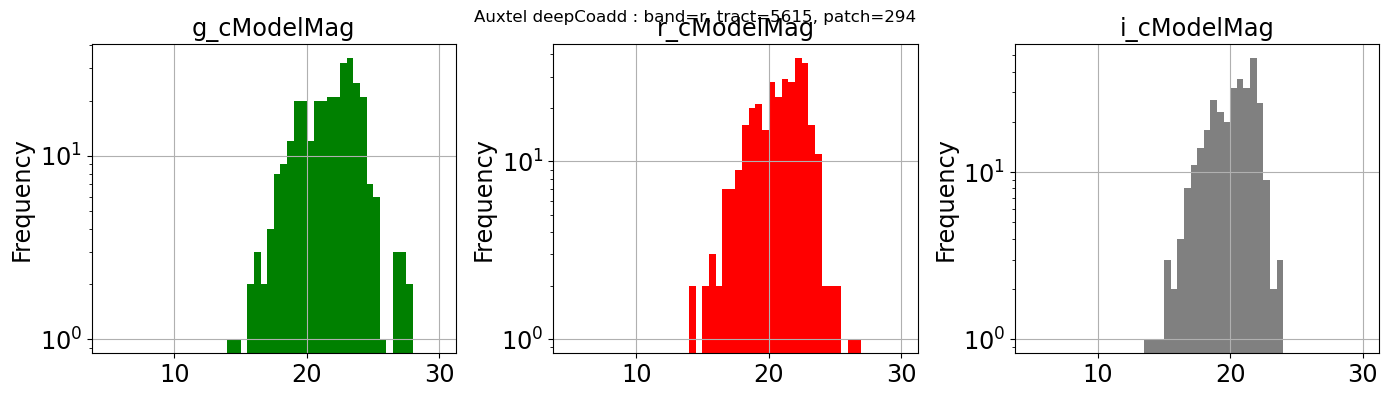

In [21]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(14,4))

df_sel['g_cModelMag'].plot(kind="hist",bins=50,range=(5,30),facecolor="g",logy=True,grid=True,title="g_cModelMag",ax=ax1)
df_sel['r_cModelMag'].plot(kind="hist",bins=50,range=(5,30),facecolor="r",logy=True,grid=True,title="r_cModelMag",ax=ax2)
df_sel['i_cModelMag'].plot(kind="hist",bins=50,range=(5,30),facecolor="grey",logy=True,grid=True,title="i_cModelMag",ax=ax3)
plt.tight_layout()
plt.suptitle(the_title)

### Plot deep Coadds without selection

In [22]:
pos_obj = df_sel[["x","y","g_ra","r_ra","i_ra", "g_dec","r_dec","i_dec" ]]
pos_obj

,x,y,g_ra,r_ra,i_ra,g_dec,r_dec,i_dec
objectId,,,,,,,,
2229049818594934813,27343.815630,45007.825523,240.035142,240.035131,240.035148,-24.086877,-24.086852,-24.086882
2229049818594934815,28454.824575,45037.561273,240.001339,240.001339,240.001344,-24.086048,-24.086048,-24.086060
2229049818594934817,29242.944133,45071.392627,239.977360,239.977363,239.977365,-24.085121,-24.085119,-24.085119
2229049818594934819,27599.689152,45067.953063,240.027353,240.027353,240.027362,-24.085212,-24.085212,-24.085213
2229049818594934820,27447.833294,45085.368859,240.031981,240.031977,240.031982,-24.084735,-24.084733,-24.084729
...,...,...,...,...,...,...,...,...
2229049818594937316,28427.600217,47850.336961,240.002189,240.002182,240.002171,-24.007943,-24.007932,-24.007933
2229049818594937322,27681.427564,47947.740057,240.024842,240.024856,240.024859,-24.005246,-24.005225,-24.005226
2229049818594937331,27158.619472,47975.688353,240.040762,240.040758,240.040756,-24.004447,-24.004444,-24.004446


In [23]:
my_deepCoadd = butler.get('deepCoadd', dataId=the_dataId,collections=my_collection)
my_deepCoadd_inputs = butler.get("deepCoadd.coaddInputs",the_dataId,collections=my_collection)   

In [24]:
my_deepCoadd_inputs.visits.asAstropy()

id,bbox_min_x,bbox_min_y,bbox_max_x,bbox_max_y,goodpix,weight,filter
,pix,pix,pix,pix,,,
int64,int32,int32,int32,int32,int32,float64,str32
2023051100262,26800,44800,30199,48199,6195750,0.039414999615975777,SDSSr_65mm~empty
2023051100268,26800,44800,30199,48199,8203937,0.04360259610284959,SDSSr_65mm~empty
2023051100273,26800,44800,30199,48199,10202020,0.047688259490096835,SDSSr_65mm~empty
2023051100274,26800,44800,30199,48199,10455159,0.045573108057791835,SDSSr_65mm~empty
2023051100279,26800,44800,30199,48199,11218394,0.047557300956504976,SDSSr_65mm~empty
2023051100280,26800,44800,30199,48199,9222544,0.047790880243608405,SDSSr_65mm~empty
2023051100285,26800,44800,30199,48199,7961405,0.04017675753032146,SDSSr_65mm~empty
2023051100286,26800,44800,30199,48199,6316701,0.0431856851369943,SDSSr_65mm~empty


(26799.5, 30199.5, 44799.5, 48199.5)

<Figure size 600x600 with 0 Axes>

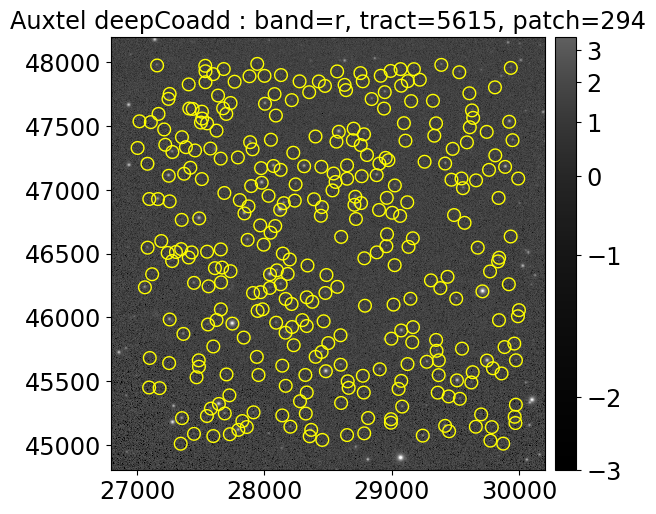

In [25]:
# Plot the calexp we just retrieved
plt.figure()
afw_display = afwDisplay.Display()
afw_display.scale('asinh', 'zscale')
afw_display.mtv(my_deepCoadd.image,title=the_title )

with afw_display.Buffering():
    for index, row in pos_obj.iterrows():
        x = row["x"]
        y = row["y"]
        afw_display.dot('o', x , y, size=50, ctype='yellow')

plt.gca().axis('on')

#plt.scatter(pos_obj.x.values,pos_obj.y.values,marker="o",color="y")

## Plot magnitude by applying Selection cut

In [26]:
selection4 = df_sel["r_cModelMag"] < 17.0
df_sel = df_sel[selection4]

Text(0.5, 0.98, 'Auxtel deepCoadd : band=r, tract=5615, patch=294')

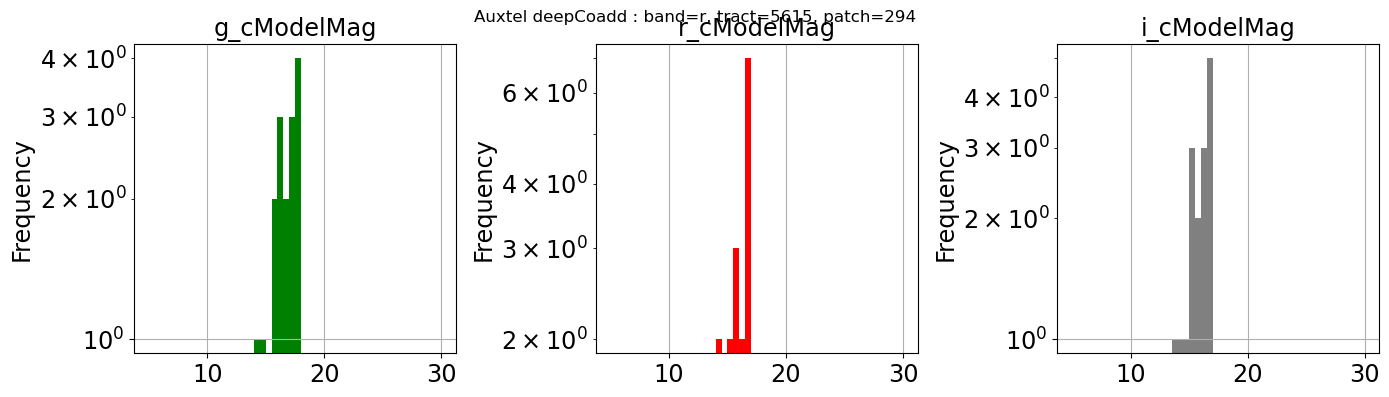

In [27]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(14,4))

df_sel['g_cModelMag'].plot(kind="hist",bins=50,range=(5,30),facecolor="g",logy=True,grid=True,title="g_cModelMag",ax=ax1)
df_sel['r_cModelMag'].plot(kind="hist",bins=50,range=(5,30),facecolor="r",logy=True,grid=True,title="r_cModelMag",ax=ax2)
df_sel['i_cModelMag'].plot(kind="hist",bins=50,range=(5,30),facecolor="grey",logy=True,grid=True,title="i_cModelMag",ax=ax3)
plt.tight_layout()
plt.suptitle(the_title)

## Position

In [28]:
#colnames = list(df_sel.columns)
#for col in colnames:
#    if "ra" in col:
#        print(col)

In [29]:
pos_obj = df_sel[["x","y","g_ra","r_ra","i_ra", "g_dec","r_dec","i_dec" ]]
pos_obj

,x,y,g_ra,r_ra,i_ra,g_dec,r_dec,i_dec
objectId,,,,,,,,
2229049818594934965,29073.841908,45896.521066,239.982512,239.982511,239.982513,-24.062199,-24.062200,-24.062201
2229049818594935199,27250.370125,47110.241244,240.037974,240.037973,240.037973,-24.028485,-24.028486,-24.028485
2229049818594935217,29889.085166,47179.842273,239.957726,239.957725,239.957725,-24.026551,-24.026552,-24.026551
2229049818594936450,27796.293812,45116.622157,240.021380,240.021381,240.021380,-24.083864,-24.083863,-24.083862
2229049818594936512,27643.628019,45320.033570,240.026025,240.026024,240.026024,-24.078213,-24.078212,-24.078212
2229049818594936560,29511.223115,45504.910312,239.969204,239.969204,239.969205,-24.073076,-24.073076,-24.073076
2229049818594936575,28482.655705,45576.717911,240.000496,240.000496,240.000497,-24.071085,-24.071084,-24.071084
2229049818594936614,29746.426734,45660.686499,239.962053,239.962052,239.962051,-24.068747,-24.068747,-24.068747
2229049818594936679,27749.457360,45950.287958,240.022800,240.022801,240.022801,-24.060707,-24.060707,-24.060706


## deepCoadd

In [30]:
my_deepCoadd = butler.get('deepCoadd', dataId=the_dataId,collections=my_collection)
my_deepCoadd_inputs = butler.get("deepCoadd.coaddInputs",the_dataId,collections=my_collection)   

In [31]:
my_deepCoadd_inputs.visits.asAstropy()

id,bbox_min_x,bbox_min_y,bbox_max_x,bbox_max_y,goodpix,weight,filter
,pix,pix,pix,pix,,,
int64,int32,int32,int32,int32,int32,float64,str32
2023051100262,26800,44800,30199,48199,6195750,0.039414999615975777,SDSSr_65mm~empty
2023051100268,26800,44800,30199,48199,8203937,0.04360259610284959,SDSSr_65mm~empty
2023051100273,26800,44800,30199,48199,10202020,0.047688259490096835,SDSSr_65mm~empty
2023051100274,26800,44800,30199,48199,10455159,0.045573108057791835,SDSSr_65mm~empty
2023051100279,26800,44800,30199,48199,11218394,0.047557300956504976,SDSSr_65mm~empty
2023051100280,26800,44800,30199,48199,9222544,0.047790880243608405,SDSSr_65mm~empty
2023051100285,26800,44800,30199,48199,7961405,0.04017675753032146,SDSSr_65mm~empty
2023051100286,26800,44800,30199,48199,6316701,0.0431856851369943,SDSSr_65mm~empty


## Compare object position with deepcoadds

(26799.5, 30199.5, 44799.5, 48199.5)

<Figure size 600x600 with 0 Axes>

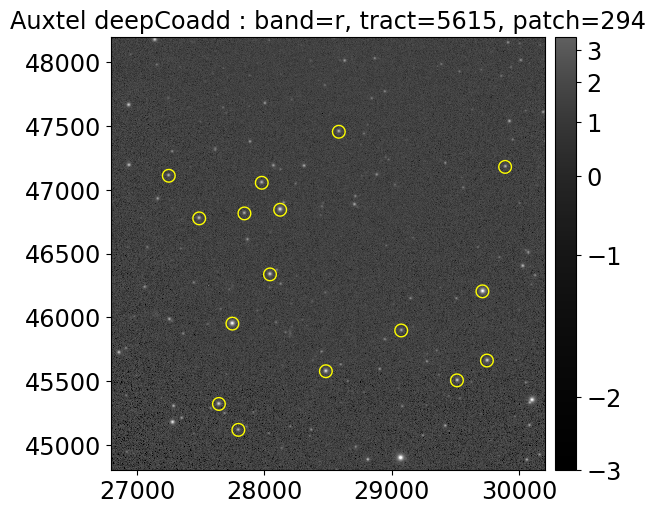

In [32]:
# Plot the calexp we just retrieved
plt.figure()
afw_display = afwDisplay.Display()
afw_display.scale('asinh', 'zscale')
afw_display.mtv(my_deepCoadd.image,title=the_title )

with afw_display.Buffering():
    for index, row in pos_obj.iterrows():
        x = row["x"]
        y = row["y"]
        afw_display.dot('o', x , y, size=50, ctype='yellow')

plt.gca().axis('on')

#plt.scatter(pos_obj.x.values,pos_obj.y.values,marker="o",color="y")

(26799.5, 30199.5, 44799.5, 48199.5)

<Figure size 1200x1200 with 0 Axes>

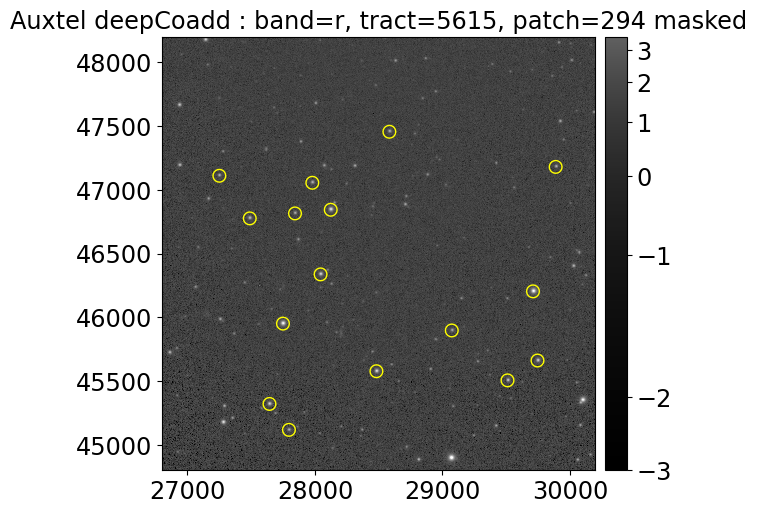

In [33]:
# Plot the calexp we just retrieved
plt.figure(figsize=(12,12))
afw_display = afwDisplay.Display(figsize=(12,12))
afw_display.scale('asinh', 'zscale')
afw_display.mtv(my_deepCoadd.maskedImage.image,title=the_title+" masked")

with afw_display.Buffering():
    for index, row in pos_obj.iterrows():
        x = row["x"]
        y = row["y"]
        afw_display.dot('o', x , y, size=50, ctype='yellow')


plt.gca().axis('on')

## Histo

Text(0.5, 1.0, 'Auxtel deepCoadd : band=r, tract=5615, patch=294')

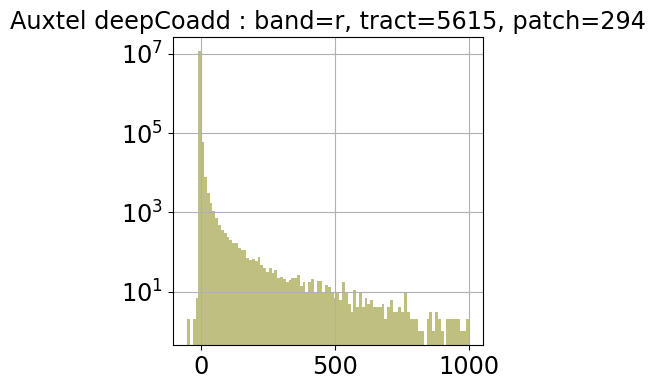

In [34]:
fig=plt.figure(figsize=(4,4))
ax=fig.add_subplot(1,1,1)
ax.hist(my_deepCoadd.image.array.flatten(),bins=100,range=(-50,1000),alpha=0.5,facecolor='blue')
ax.hist(my_deepCoadd.maskedImage.image.array.flatten(),bins=100,range=(-50,1000),alpha=0.5,facecolor="yellow")
ax.set_yscale('log')
ax.grid()
ax.set_title(the_title)